# Update Recent Stock Prices and Visualize
This notebook updates the `assets.db` with the latest stock prices from Alpaca, queries stock prices for a specific ticker over a date range, and plots the OHLC (Open, High, Low, Close) prices with user-selectable smoothing methods (exponential smoothing, LOWESS, or moving average).

In [1]:
import pandas as pd
import sqlite3
from datetime import datetime, timedelta  
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import statsmodels.api as sm
import sys
from pathlib import Path
import os

# Define BASE_DIR and adjust sys.path before importing
BASE_DIR = Path(os.getcwd()).parent  # Points to stat_656_autotrader/ from Notebooks/
sys.path.append(str(BASE_DIR))
print(f"Project root added to sys.path: {BASE_DIR}")

# Import paths from the config module
from src.config import BASE_DIR, DB_DIR
from credentials import ALPACA_API_KEY, ALPACA_SECRET_KEY, ALPAKA_ENDPOINT_URL

from src.utils.alpaca_utils import connect_to_alpaca, fetch_alpaca_stock_tickers
from src.utils.db_utils import get_db_connection, fetch_active_tickers, last_data_date, last_fetch_date, fetch_database_stock_tickers
from src.visualizations.stock_price_trends import plot_stock_trends
from src.statistics.smoothers import smooth_lowess

Project root added to sys.path: d:\dev\stat_656_autotrader


# Connect and Fetch Tickers

In [2]:
# Obtainthe last datetime date.
last_data_date()

KeyboardInterrupt: 

In [ ]:


alpaca_client = connect_to_alpaca(ALPACA_API_KEY, ALPACA_SECRET_KEY, ALPAKA_ENDPOINT_URL)
alpaca_tickers = fetch_alpaca_stock_tickers(alpaca_client, exchanges=['NASDAQ', 'NYSE', 'AMEX'])
db_tickers = fetch_database_stock_tickers()


In [6]:
def compare_ticker_lists(db_tickers, alpaca_tickers):
    """Compare two lists of stock tickers and identify dropped and added tickers.

    Parameters
    ----------
    db_tickers : list
        List of ticker symbols from the database (e.g., from fetch_database_stock_tickers).
    alpaca_tickers : list
        List of ticker symbols from Alpaca API (e.g., from fetch_alpaca_stock_tickers).

    Returns
    -------
    tuple
        A tuple containing two lists:
        - dropped_tickers: List of tickers present in db_tickers but not in alpaca_tickers.
        - added_tickers: List of tickers present in alpaca_tickers but not in db_tickers.

    Examples
    --------
    >>> db_list = ['AAPL', 'GOOGL', 'FB']
    >>> alpaca_list = ['AAPL', 'TSLA', 'GOOGL']
    >>> dropped, added = compare_ticker_lists(db_list, alpaca_list)
    >>> print("Dropped:", dropped)
    Dropped: ['FB']
    >>> print("Added:", added)
    Added: ['TSLA']
    """
    # Convert lists to sets for efficient comparison
    db_set = set(db_tickers)
    alpaca_set = set(alpaca_tickers)
    
    # Find tickers in db_tickers but not in alpaca_tickers (dropped)
    dropped_tickers = list(db_set - alpaca_set)
    
    # Find tickers in alpaca_tickers but not in db_tickers (added)
    added_tickers = list(alpaca_set - db_set)
    
    return dropped_tickers, added_tickers

In [7]:
compare_ticker_lists(db_tickers, alpaca_tickers)

(['GLACU',
  'SBT',
  'GATEW',
  'IACVV',
  'ITCI',
  'GATE',
  'SASR',
  'IVAC',
  'FBMS',
  'VOXX',
  'GLAC',
  'TBNK',
  'VRPX',
  'HCVIU',
  'SHLT',
  'GATEU',
  'HCVI',
  'APTO',
  'LGTY',
  'EDOC',
  'STSB',
  'AIM',
  'PTVE',
  'HCVIW',
  'TCTM',
  'DM',
  'GLACR',
  'VBFC',
  'NVRO',
  'GXTG',
  'EFSH'],
 ['HEAL',
  'GLDY',
  'TOROV',
  'WSML',
  'WXM',
  'ATII',
  'AACB',
  'SMA',
  'LHSW',
  'WTF',
  'ENGS',
  'GXDW',
  'SHOP',
  'KIDZW',
  'XYZG',
  'GIND',
  'WTMU',
  'ATIIW',
  'TEKY',
  'BLIV',
  'WTMY',
  'CRMG',
  'RGTX',
  'SDHIU',
  'JOYY',
  'SMCZ',
  'PYPG',
  'FMUN',
  'JPY',
  'KIDZ',
  'SZZLU',
  'FMUB',
  'RBNEV',
  'AACBR',
  'THMZ'])

In [5]:
stock_assets

['PBF',
 'PBFS',
 'PBH',
 'PBHC',
 'PBI',
 'OP',
 'PBM',
 'PBMWW',
 'PBPB',
 'PBQQ',
 'PBR',
 'PBT',
 'PBYI',
 'PC',
 'PCAR',
 'PCB',
 'PCF',
 'PCG',
 'PCK',
 'PCLA',
 'PCM',
 'PCMM',
 'PCN',
 'PCOR',
 'PCQ',
 'PCRX',
 'PCSA',
 'PCSC',
 'PCT',
 'PCTTU',
 'PCTTW',
 'PCTY',
 'PCVX',
 'PCYO',
 'PDBA',
 'PDBC',
 'PDCC',
 'PDCO',
 'PDD',
 'PDEX',
 'PDFS',
 'PDI',
 'PDLB',
 'PDM',
 'PDO',
 'PDP',
 'PDPA',
 'PDS',
 'PDSB',
 'PDT',
 'PDX',
 'PDYN',
 'PDYNW',
 'PEB',
 'BRX',
 'PEBK',
 'PEBO',
 'PECO',
 'PEG',
 'PEGA',
 'PEN',
 'PENG',
 'PENN',
 'PEO',
 'PEP',
 'PEPG',
 'PEPS',
 'PERF',
 'PERI',
 'PESI',
 'PET',
 'PETS',
 'PETWW',
 'PETZ',
 'PEV',
 'PEY',
 'PEZ',
 'PFBC',
 'PFD',
 'PFE',
 'PFF',
 'PFG',
 'PFGC',
 'PFH',
 'PFI',
 'PFM',
 'PFN',
 'PFO',
 'PFS',
 'PFSI',
 'PFX',
 'PFXNZ',
 'PG',
 'PGEN',
 'PGJ',
 'PGNY',
 'PGP',
 'PGR',
 'PGRE',
 'PGYWW',
 'PGZ',
 'PH',
 'PHAR',
 'PHAT',
 'PHG',
 'PHGE',
 'PHH',
 'PHIN',
 'PHIO',
 'PHK',
 'PHLT',
 'PHM',
 'PHO',
 'PHR',
 'PHT',
 'PHUN',
 'PHVS',
 '

In [17]:
def fetch_database_stock_tickers()
    conn = get_db_connection('assets.db', print_statements=False)
    query = """
    SELECT symbol FROM asset_metadata
    """
    past_ticker_list = pd.read_sql(query, conn)['symbol'].to_list()
    conn.close()
    return past_ticker_list 

['A',
 'AA',
 'AACBU',
 'AACG',
 'AACT',
 'AADR',
 'AAL',
 'AAM',
 'AAME',
 'AAMI',
 'AAOI',
 'AAON',
 'AAP',
 'AAPB',
 'AAPD',
 'AAPG',
 'AAPL',
 'AAPU',
 'AARD',
 'AAT',
 'AAVM',
 'AAXJ',
 'AB',
 'ABAT',
 'ABBV',
 'ABCB',
 'ABCL',
 'ABCS',
 'ABEO',
 'ABEV',
 'ABG',
 'ABL',
 'ABLLL',
 'ABLLW',
 'ABLVW',
 'ABM',
 'ABNB',
 'ABOS',
 'ABP',
 'ABPWW',
 'ABR',
 'ABSI',
 'ABT',
 'ABTS',
 'ABUS',
 'ABVC',
 'ABVE',
 'ABVEW',
 'ABVX',
 'AC',
 'ACA',
 'ACAD',
 'ACB',
 'ACCD',
 'ACCO',
 'ACCS',
 'ACDC',
 'ACEL',
 'ACET',
 'ACGL',
 'ACGLN',
 'ACGLO',
 'ACHC',
 'ACHR',
 'ACHV',
 'ACI',
 'ACIC',
 'ACIU',
 'ACIW',
 'ACLO',
 'ACLS',
 'ACLX',
 'ACM',
 'ACMR',
 'ACN',
 'ACNB',
 'ACNT',
 'ACOG',
 'ACON',
 'ACONW',
 'ACP',
 'ACR',
 'ACRE',
 'ACRS',
 'ACRV',
 'ACT',
 'ACTG',
 'ACTU',
 'ACU',
 'ACV',
 'ACVA',
 'ACWI',
 'ACWX',
 'ACXP',
 'ADAG',
 'ADAP',
 'ADBE',
 'ADBG',
 'ADC',
 'ADCT',
 'ADD',
 'ADEA',
 'ADGM',
 'ADI',
 'ADIL',
 'ADM',
 'ADMA',
 'ADN',
 'ADNT',
 'ADNWW',
 'ADP',
 'ADPT',
 'ADSE',
 'ADSEW'

In [11]:
fetch_existing_tickers()

ProgrammingError: Cannot operate on a closed database.

In [7]:
df = fetch_all_asset_metadata()
df.head()

Connecting to database: D:\dev\stat_656_autotrader\databases\assets.db
Raw rows fetched: [(1, 'CCLDO', 'CareCloud, Inc. 8.75% Series B Cumulative Redeemable Perpetual Preferred Stock', 'NASDAQ', 'us_equity', 1, '2025-03-31', None, '2025-03-31 01:26:01'), (2, 'BHVN', 'Biohaven Ltd.', 'NYSE', 'us_equity', 1, '2025-03-31', None, '2025-03-31 01:26:01'), (3, 'ZUMZ', 'Zumiez Inc. Common Stock', 'NASDAQ', 'us_equity', 1, '2025-03-31', None, '2025-03-31 01:26:01'), (4, 'EMR', 'Emerson Electric Co.', 'NYSE', 'us_equity', 1, '2025-03-31', None, '2025-03-31 01:26:01'), (5, 'CCL', 'Carnival Corporation', 'NYSE', 'us_equity', 1, '2025-03-31', None, '2025-03-31 01:26:01')]
Column names from DB: ['asset_id', 'symbol', 'name', 'exchange', 'asset_type', 'is_active', 'date_added', 'date_removed', 'fetched_at']


,asset_id,symbol,name,exchange,asset_type,is_active,date_added,date_removed,fetched_at
0,1,CCLDO,"CareCloud, Inc. 8.75% Series B Cumulative Rede...",NASDAQ,us_equity,1,2025-03-31,None,2025-03-31 01:26:01
1,2,BHVN,Biohaven Ltd.,NYSE,us_equity,1,2025-03-31,None,2025-03-31 01:26:01
2,3,ZUMZ,Zumiez Inc. Common Stock,NASDAQ,us_equity,1,2025-03-31,None,2025-03-31 01:26:01
3,4,EMR,Emerson Electric Co.,NYSE,us_equity,1,2025-03-31,None,2025-03-31 01:26:01
4,5,CCL,Carnival Corporation,NYSE,us_equity,1,2025-03-31,None,2025-03-31 01:26:01


In [3]:

price_data = pd.read_sql_query(query, conn, params=(sample_ticker,))
price_data['date'] = pd.to_datetime(price_data['date'])
conn.close()
print(f"Fetched {len(price_data)} price records for {sample_ticker}")

Connecting to database: D:\dev\stat_656_autotrader\databases\assets.db
Fetched 2323 price records for MSFT


In [4]:
price_data

,date,close
0,2016-01-04,54.80
1,2016-01-05,55.05
2,2016-01-06,54.05
3,2016-01-07,52.17
4,2016-01-08,52.33
...,...,...
2318,2025-03-24,393.08
2319,2025-03-25,395.16
2320,2025-03-26,389.97
2321,2025-03-27,390.58


In [19]:
def fetch_price_range(ticker, days_back, conn=None):
    """
    Fetch OHLC price data for a ticker from assets.db for a range of days back from the most recent date.
    
    Args:
        ticker (str): Stock ticker symbol (e.g., 'AAPL').
        days_back (int): Number of days to look back from the most recent date.
        conn (sqlite3.Connection, optional): Existing database connection; if None, creates a new one.
    
    Returns:
        pd.DataFrame: OHLC data with columns ['date', 'open', 'high', 'low', 'close'].
    """
    close_conn = False
    if conn is None:
        conn = get_db_connection('assets.db')
        close_conn = True

    cursor = conn.cursor()
    cursor.execute("""
        SELECT MAX(date)
        FROM asset_prices
        WHERE asset_id = (SELECT asset_id FROM asset_metadata WHERE symbol = ?)
    """, (ticker,))
    most_recent_date = cursor.fetchone()[0]

    if most_recent_date:
        most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
        start_date = most_recent_date - timedelta(days=days_back)
        start_date_str = start_date.strftime('%Y-%m-%d')
        print(f"Querying {ticker} prices from {start_date_str} to {most_recent_date.strftime('%Y-%m-%d')}")
        
        query = """
            SELECT date, open, high, low, close
            FROM asset_prices
            WHERE asset_id = (SELECT asset_id FROM asset_metadata WHERE symbol = ?)
            AND date >= ?
            ORDER BY date ASC
        """
        price_data = pd.read_sql_query(query, conn, params=(ticker, start_date_str))
        price_data['date'] = pd.to_datetime(price_data['date'])
        print(f"Fetched {len(price_data)} price records for {ticker}")
    else:
        print(f"No price data found for {ticker} in assets.db")
        price_data = pd.DataFrame(columns=['date', 'open', 'high', 'low', 'close'])

    if close_conn:
        conn.close()
    
    return price_data

In [ ]:
# Cell 2: Connect and Fetch Tickers
conn = get_db_connection('assets.db')
print("Connected to assets.db")

active_tickers = fetch_active_tickers()
print(f"Found {len(active_tickers)} active tickers: {list(active_tickers.keys())[:5]}...")


Connecting to database: D:\dev\stat_656_autotrader\databases\assets.db
Connected to assets.db
Connecting to database: D:\dev\stat_656_autotrader\databases\assets.db
Found 7462 active tickers: ['CCLDO', 'BHVN', 'ZUMZ', 'EMR', 'CCL']...
Querying AAPL prices from 2025-02-26 to 2025-03-28
Fetched 23 price records for AAPL


Querying AAPL prices from 2024-11-28 to 2025-03-28
Fetched 81 price records for AAPL


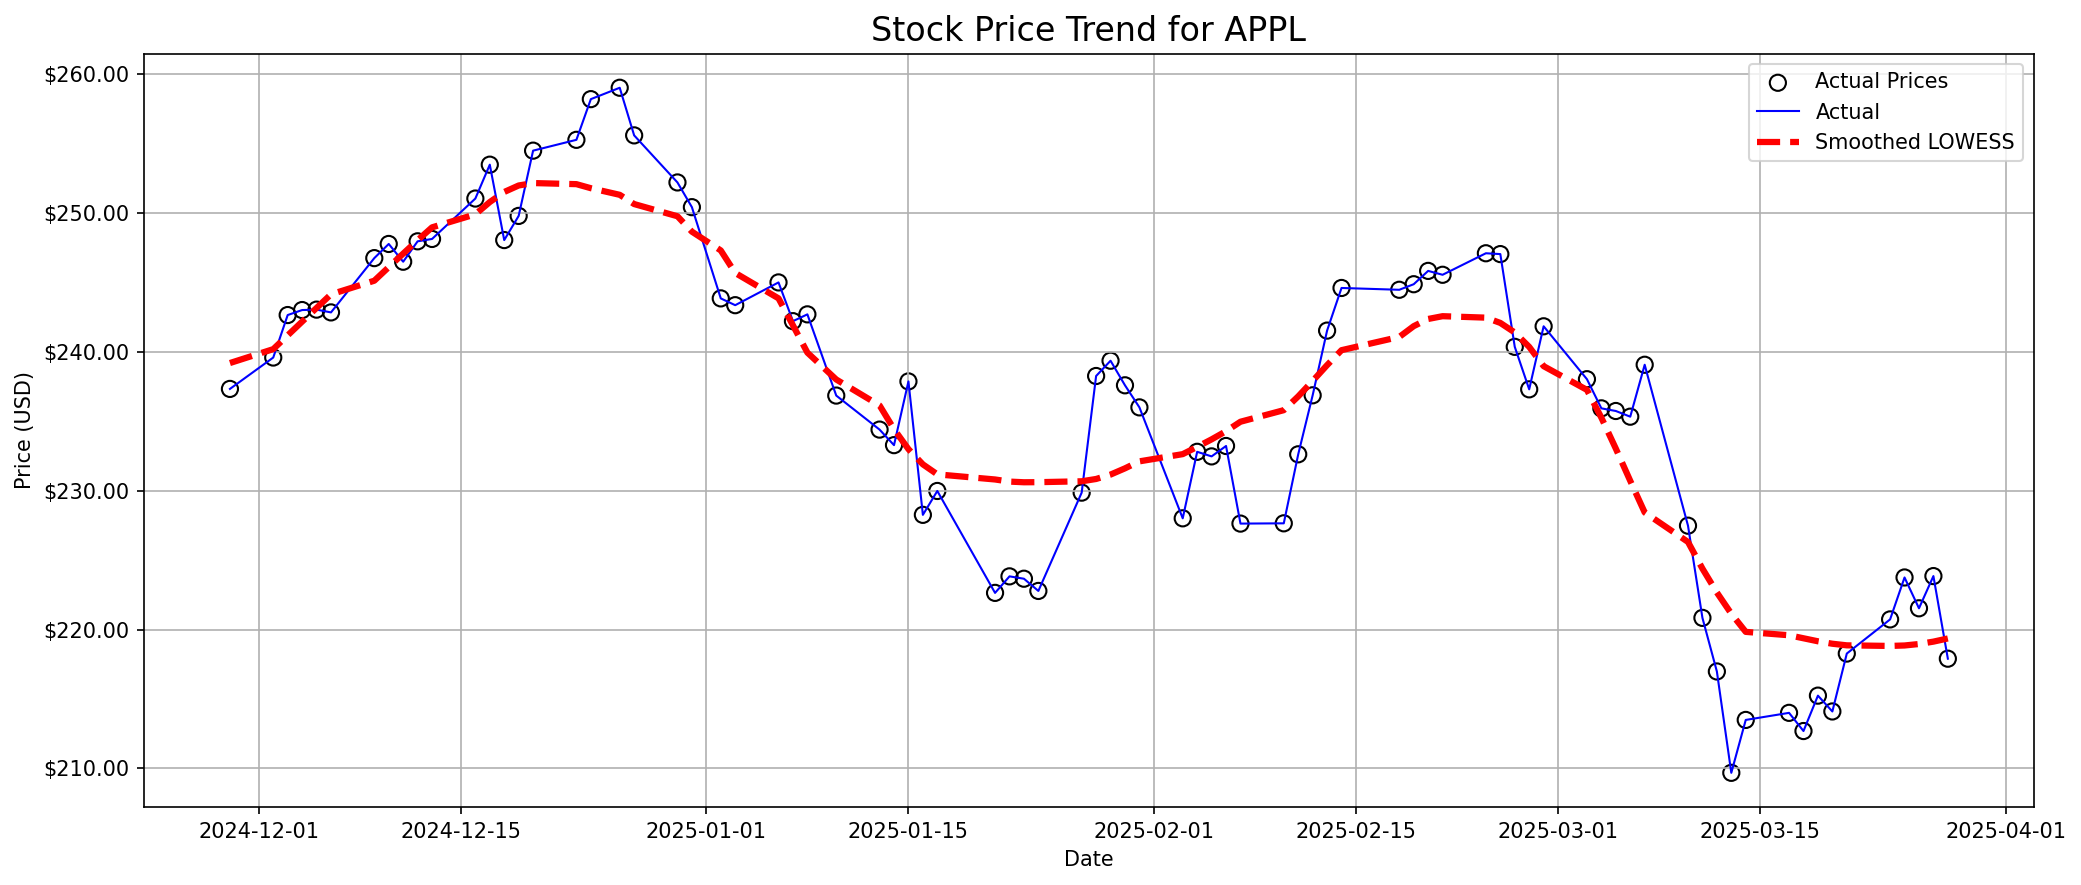

,date,open,high,low,close
51,2025-02-14,241.250,245.5500,240.9900,244.60
52,2025-02-18,244.150,245.1800,241.8400,244.47
53,2025-02-19,244.660,246.0100,243.1604,244.87
54,2025-02-20,244.940,246.7800,244.2900,245.83
55,2025-02-21,245.950,248.6900,245.2200,245.55
56,2025-02-24,244.925,248.8600,244.4200,247.10
57,2025-02-25,248.000,250.0000,244.9100,247.04
58,2025-02-26,244.330,244.9800,239.1300,240.36
59,2025-02-27,239.410,242.4600,237.0600,237.30
60,2025-02-28,236.950,242.0900,230.2000,241.84


In [24]:
sample_ticker = 'AAPL'
days_back = 120

price_data = fetch_price_range(sample_ticker, days_back, conn=conn)
plot_stock_trends(price_data['date'], price_data['close'], 'APPL')
display(price_data.tail(30))

# Update Recent Stock Prices

In [5]:
# Initialize Alpaca client
alpaca = get_alpaca_client()

# Update stock prices for active tickers (e.g., last 5 days)
start_date = datetime.now() - timedelta(days=5)
end_date = datetime.now()

# Pass conn to update_stock_prices (assuming it’s updated to accept conn elsewhere)
updated_tickers = update_stock_prices(alpaca, conn, list(active_tickers.keys()), start_date, end_date)
print(f"Updated prices for {len(updated_tickers)} tickers")

NameError: name 'timedelta' is not defined